##  Predict Tomorrow’s Closing Price For a Specific Company

### Import Libraries

In [13]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import os

### Prepare for Time Series Forecasting

In [22]:
def fetch_and_save_data(symbols, interval='daily', outputsize='full'):
    api_key = os.getenv('ALPHAVANTAGE_API_KEY')  
    ts = TimeSeries(key=api_key, output_format='pandas')
    
    if not os.path.exists('data'):
        os.makedirs('data')
    
    for symbol in symbols:
        data, meta_data = ts.get_daily(symbol=symbol, outputsize=outputsize)
        data.to_csv(f'../data/daily/{symbol}_daily.csv')

# List of symbols for different companies
symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META'] 
# fetch_and_save_data(symbols)

def load_and_preprocess_data(symbol):
    data = pd.read_csv(f'../data/daily/{symbol}_daily.csv')
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    data['close_normalized'] = (data['4. close'] - data['4. close'].mean()) / data['4. close'].std()
    data['close_lagged_1'] = data['4. close'].shift(1)
    data['close_lagged_2'] = data['4. close'].shift(2)
    data['close_lagged_3'] = data['4. close'].shift(3)
    data.dropna(inplace=True)
    return data

symbol = 'AAPL'
company_data = load_and_preprocess_data(symbol)

company_data = company_data.sort_values(by='date')

company_data.to_csv(f'../data/processed/{symbol}_processed.csv')

In [23]:
# Load preprocessed data for a specific company
data = pd.read_csv(f'../data/processed/{symbol}_processed.csv', parse_dates=['date'])
data.set_index('date', inplace=True)

features = ['1. open', '2. high', '3. low', '5. volume', 'close_lagged_1', 'close_lagged_2', 'close_lagged_3']
target = '4. close'

X = data[features]
y = data[target]

### Train the Model on Historical Data

Linear Regression - MSE: 1.4608519475930275, R^2: 0.9995927716503237
Decision Tree - MSE: 7.17776778644328, R^2: 0.9979991192571914
Random Forest - MSE: 2.849954542594376, R^2: 0.999205544212098
Gradient Boosting - MSE: 6.199846348077151, R^2: 0.9982717254813301


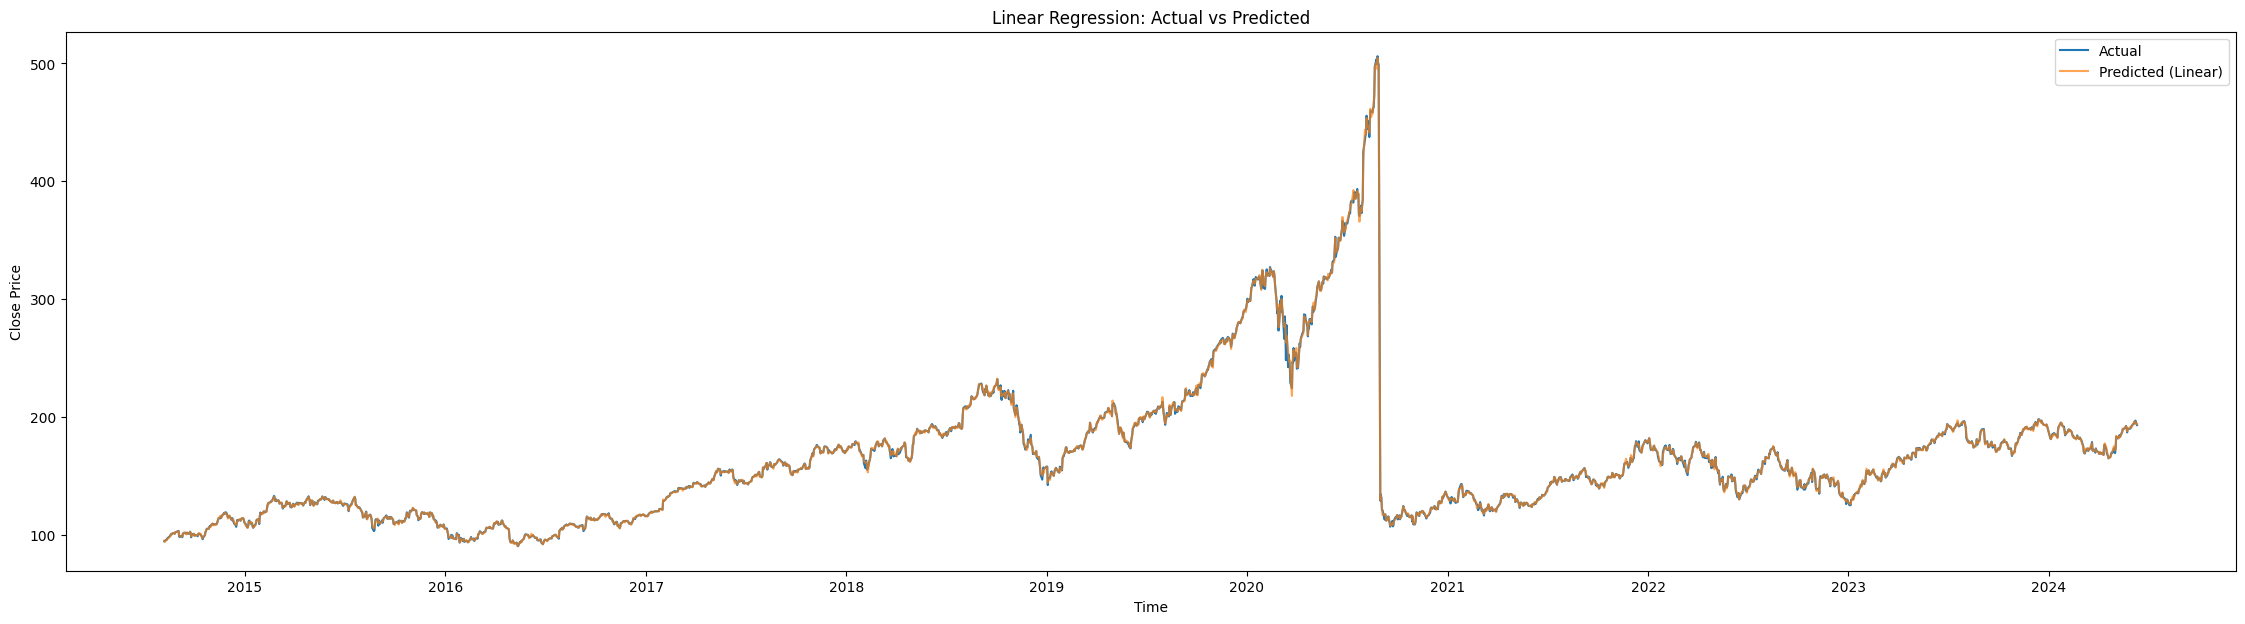

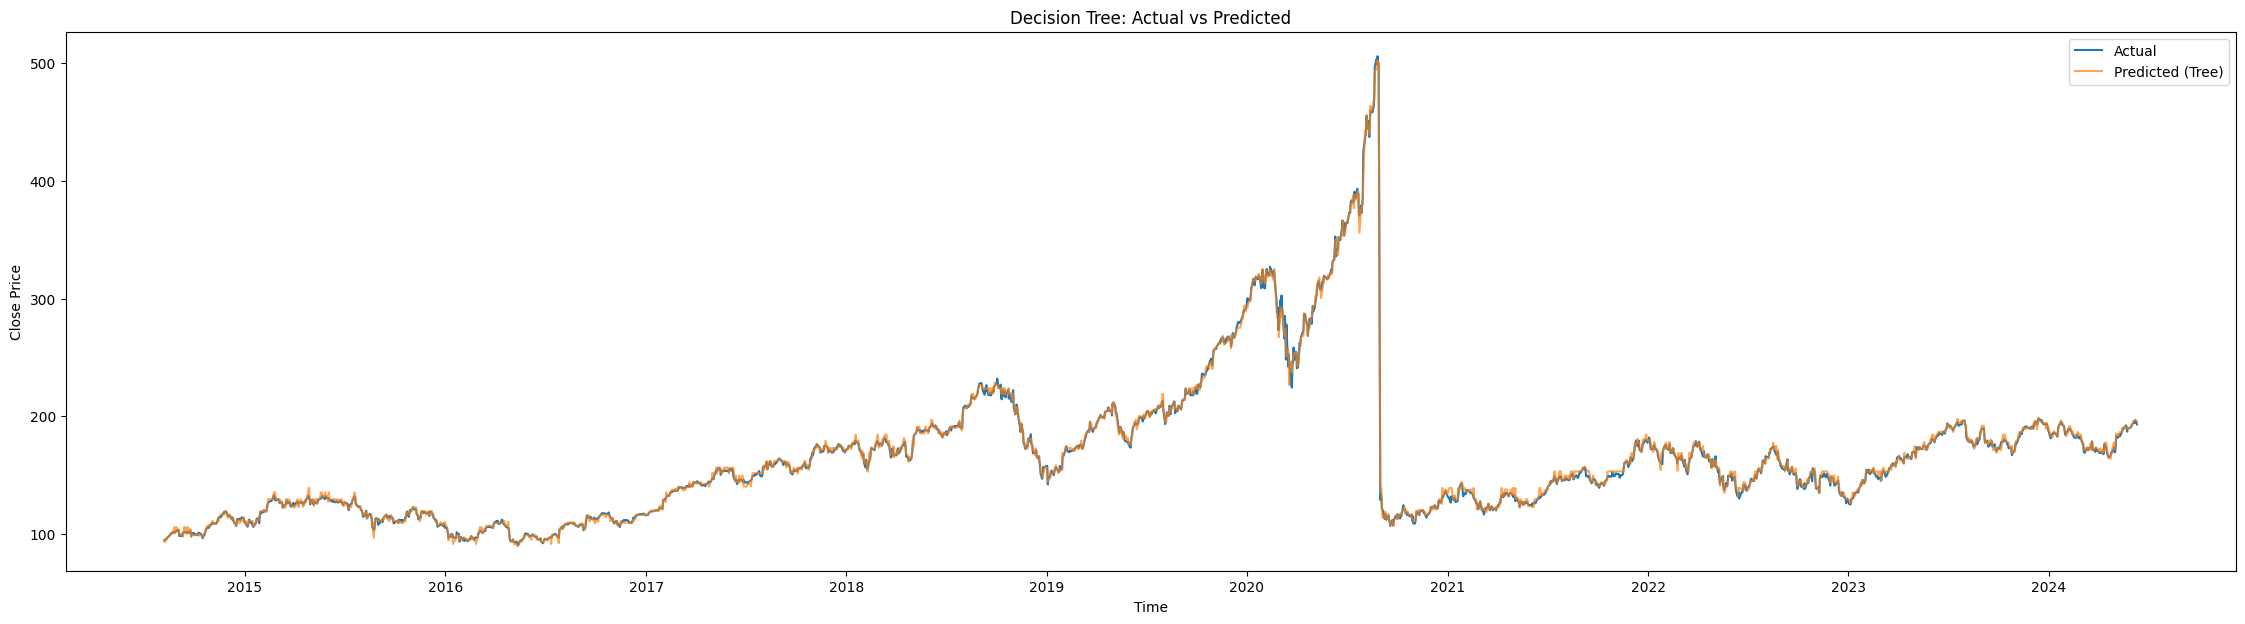

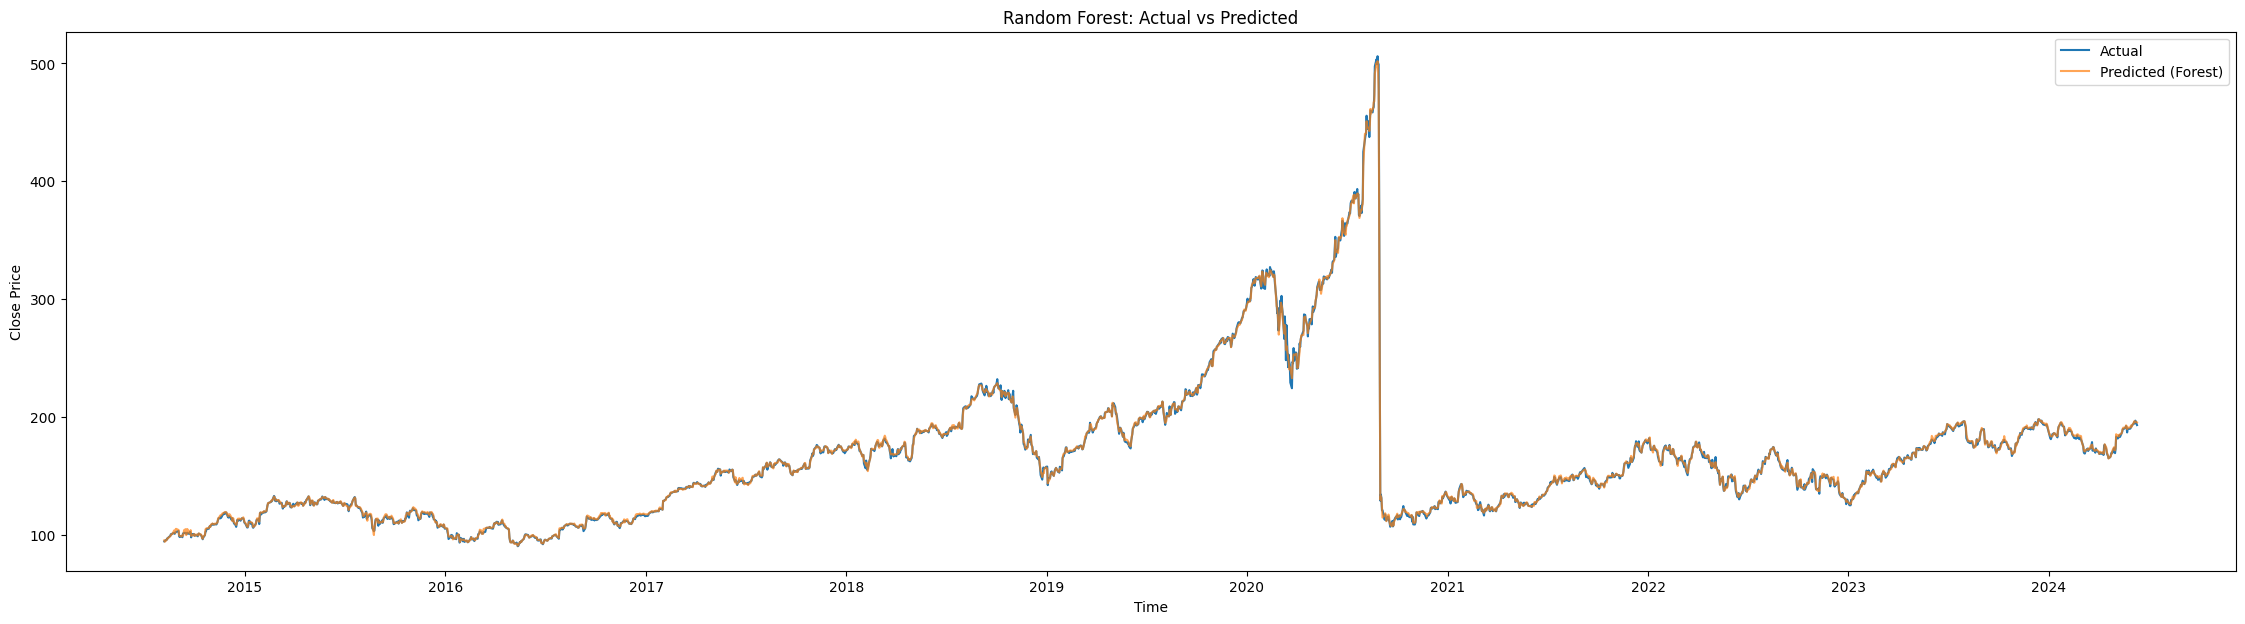

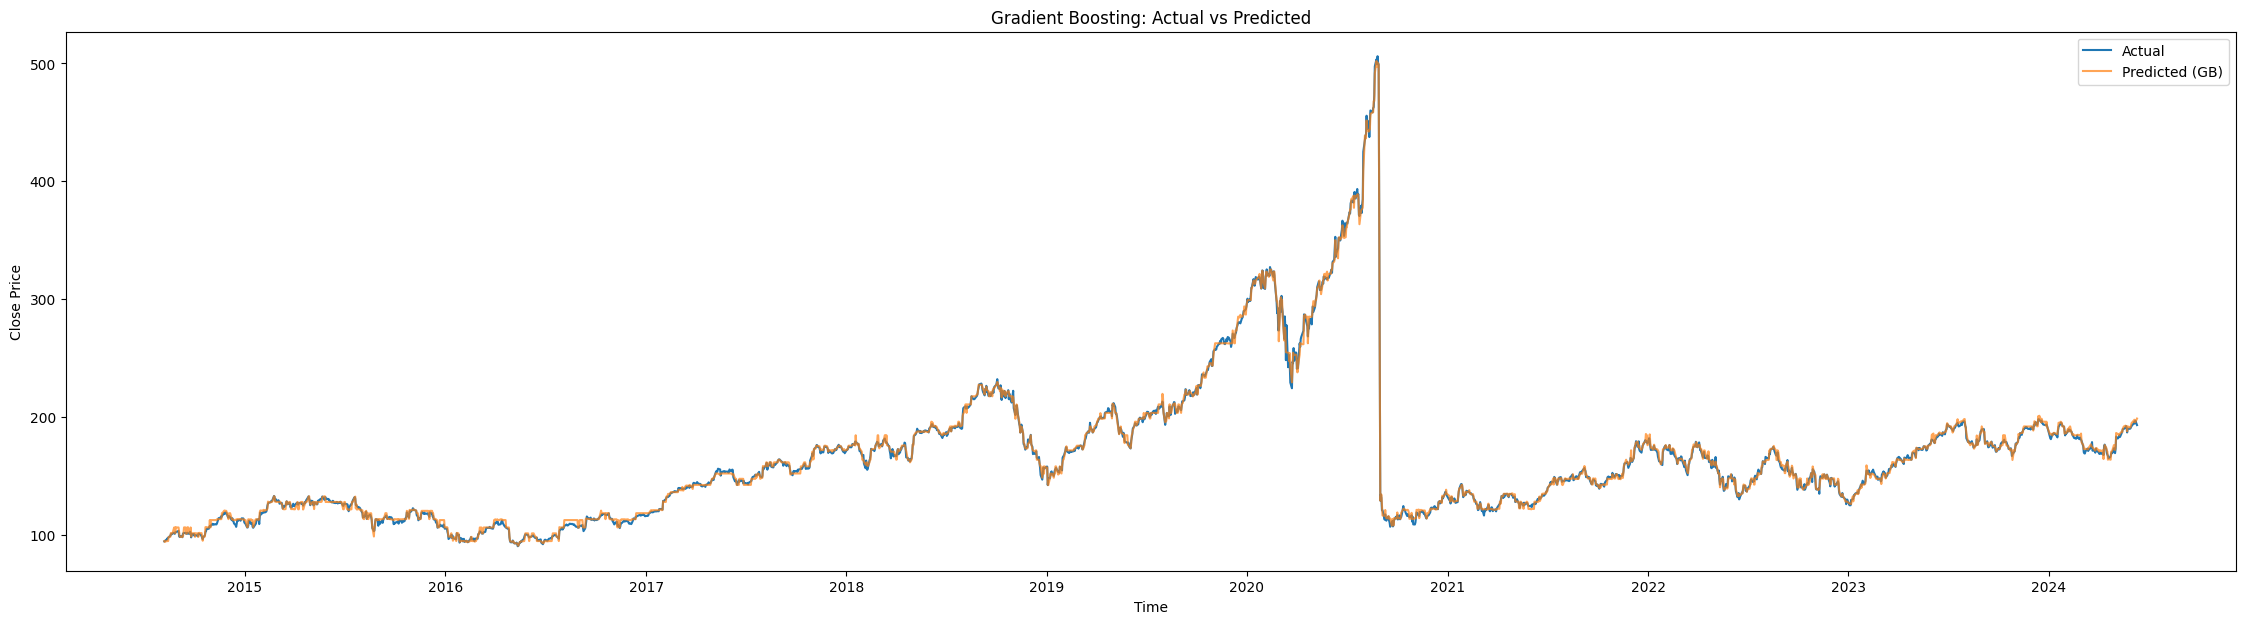

In [28]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

# Train models
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)

forest_model = RandomForestRegressor(n_estimators=100)
forest_model.fit(X_train, y_train)

gb_model = GradientBoostingRegressor(n_estimators=100)
gb_model.fit(X_train, y_train)

# Evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2, y_pred

mse_linear, r2_linear, y_pred_linear = evaluate_model(linear_model, X_test, y_test)
mse_tree, r2_tree, y_pred_tree = evaluate_model(tree_model, X_test, y_test)
mse_forest, r2_forest, y_pred_forest = evaluate_model(forest_model, X_test, y_test)
mse_gb, r2_gb, y_pred_gb = evaluate_model(gb_model, X_test, y_test)

print(f"Linear Regression - MSE: {mse_linear}, R^2: {r2_linear}")
print(f"Decision Tree - MSE: {mse_tree}, R^2: {r2_tree}")
print(f"Random Forest - MSE: {mse_forest}, R^2: {r2_forest}")
print(f"Gradient Boosting - MSE: {mse_gb}, R^2: {r2_gb}")

plt.figure(figsize=(28, 7))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_linear, label='Predicted (Linear)', alpha=0.7)
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

plt.figure(figsize=(28, 7))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_tree, label='Predicted (Tree)', alpha=0.7)
plt.title('Decision Tree: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

plt.figure(figsize=(28, 7))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_forest, label='Predicted (Forest)', alpha=0.7)
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

plt.figure(figsize=(28, 7))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_gb, label='Predicted (GB)', alpha=0.7)
plt.title('Gradient Boosting: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [27]:
# Get the most recent data point
latest_data = data[features].iloc[-1].values.reshape(1, -1)

# Predict tomorrow's closing price
tomorrow_pred_linear = linear_model.predict(latest_data)
tomorrow_pred_tree = tree_model.predict(latest_data)
tomorrow_pred_forest = forest_model.predict(latest_data)
tomorrow_pred_gb = gb_model.predict(latest_data)

print(f"Predicted Closing Price for Tomorrow (Linear Regression): {tomorrow_pred_linear[0]}")
print(f"Predicted Closing Price for Tomorrow (Decision Tree): {tomorrow_pred_tree[0]}")
print(f"Predicted Closing Price for Tomorrow (Random Forest): {tomorrow_pred_forest[0]}")
print(f"Predicted Closing Price for Tomorrow (Gradient Boosting): {tomorrow_pred_gb[0]}")

Predicted Closing Price for Tomorrow (Linear Regression): 193.88736075972184
Predicted Closing Price for Tomorrow (Decision Tree): 195.43
Predicted Closing Price for Tomorrow (Random Forest): 195.29657099999986
Predicted Closing Price for Tomorrow (Gradient Boosting): 194.85984630608894


c:\Users\ckand\OneDrive\Desktop\hft_analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\ckand\OneDrive\Desktop\hft_analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\ckand\OneDrive\Desktop\hft_analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\ckand\OneDrive\Desktop\hft_analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
